2026-02-13 22:21:24.690 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-13 22:21:24.691 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-13 22:21:24.693 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-13 22:21:25.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-13 22:21:25.566 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-13 22:21:25.568 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-13 22:21:25.755 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-13 22:21:26.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

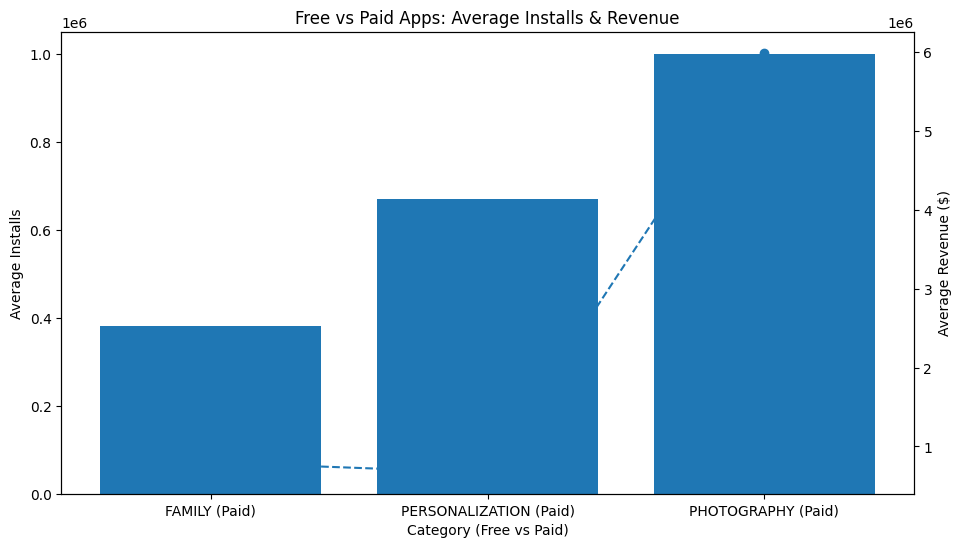

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st

# --------------------------------
# Title
# --------------------------------
st.title("📊 Free vs Paid Apps: Installs & Revenue Analysis")

# --------------------------------
# Load Data
# --------------------------------
df = pd.read_csv("googleplaystore.csv")

# Normalize column names
df.columns = df.columns.str.strip().str.lower()

# --------------------------------
# SAFE DATA CLEANING
# --------------------------------

# Installs
df['installs'] = (
    df['installs']
    .astype(str)
    .str.replace('[+,]', '', regex=True)
)
df['installs'] = pd.to_numeric(df['installs'], errors='coerce')

# Price
df['price'] = (
    df['price']
    .astype(str)
    .str.replace('$', '', regex=False)
)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Revenue = Price × Installs
df['revenue'] = df['price'] * df['installs']

# Android Version
df['android ver'] = (
    df['android ver']
    .astype(str)
    .str.extract(r'(\d+\.?\d*)')
)
df['android ver'] = pd.to_numeric(df['android ver'], errors='coerce')

# Size (MB)
df['size'] = (
    df['size']
    .astype(str)
    .str.replace('M', '', regex=False)
)
df['size'] = pd.to_numeric(df['size'], errors='coerce')

# --------------------------------
# APPLY ALL FILTERS
# --------------------------------
df = df[
    (df['installs'] >= 10000) &
    (df['revenue'] >= 10000) &
    (df['android ver'] > 4.0) &
    (df['size'] > 15) &
    (df['content rating'] == 'Everyone') &
    (df['app'].str.len() <= 30)
]

# --------------------------------
# TOP 3 CATEGORIES
# --------------------------------
top_categories = (
    df.groupby('category')['installs']
    .mean()
    .sort_values(ascending=False)
    .head(3)
    .index
)

df = df[df['category'].isin(top_categories)]

# --------------------------------
# AGGREGATE DATA
# --------------------------------
summary = (
    df.groupby(['category', 'type'])
    .agg(
        avg_installs=('installs', 'mean'),
        avg_revenue=('revenue', 'mean')
    )
    .reset_index()
)

# --------------------------------
# DISPLAY GRAPH
# --------------------------------
if summary.empty:
    st.warning("⚠️ No data available after applying filters.")
else:
    st.subheader("📈 Dual-Axis Chart: Installs vs Revenue")

    fig, ax1 = plt.subplots(figsize=(11, 6))
    x = summary['category'] + " (" + summary['type'] + ")"

    # Bar chart → Average Installs
    ax1.bar(x, summary['avg_installs'])
    ax1.set_xlabel("Category (Free vs Paid)")
    ax1.set_ylabel("Average Installs")

    # Line chart → Average Revenue
    ax2 = ax1.twinx()
    ax2.plot(x, summary['avg_revenue'], marker='o', linestyle='--')
    ax2.set_ylabel("Average Revenue ($)")

    ax1.set_title("Free vs Paid Apps: Average Installs & Revenue")

    plt.xticks(rotation=30)
    st.pyplot(fig)